# Project Outline: Representation Learning Study on CIFAR-10

## 1. Introduction and Objective
- **Goal**: To investigate how different data representations (spatial domain, FFT, DCT, wavelets) impact deep learning model performance and feature learning.
- **Research Questions**:
  - Which representation yields the best performance and generalization?
  - What common and unique features do models learn from each representation?
  - How correlated are the learned features across different data representations?
- **Expected Outcome**: Insights into the usefulness of each data representation for model training and practical recommendations for selecting data preprocessing techniques.

## 2. Data Preprocessing and Representation Generation
### 2.1. Load CIFAR-10 Dataset
- Load CIFAR-10 training and test data.
- Normalize the pixel values to the range [0, 1].

### 2.2. Generate Data Representations
- **Spatial Domain**: Use the original RGB images.
- **FFT (Frequency/Spectral Domain)**:
  - Apply 2D FFT to transform images into the frequency domain.
  - Separate the real and imaginary parts to create a 6-channel representation.
- **DCT (Discrete Cosine Transform)**:
  - Apply 2D DCT to each channel for frequency analysis.
- **Wavelet Transform**:
  - Use a multi-resolution wavelet transform (e.g., Haar wavelet) to extract image details at different scales.

## 3. Model Building and Training
### 3.1. Model Architecture
- Build a simple CNN architecture for consistent comparisons across representations:
  - Multiple convolutional and pooling layers.
  - Batch normalization and dropout for regularization.
  - A fully connected layer followed by a softmax output layer.

### 3.2. Training Procedure
- Compile models with a suitable optimizer (e.g., Adam) and loss function (categorical cross-entropy).
- Train each model on the respective data representation with:
  - Early stopping for overfitting prevention.
  - Learning rate reduction upon plateau.

## 4. Feature Extraction and Visualization
### 4.1. Activation Map Extraction
- Extract intermediate activation maps from selected layers to visualize which features are emphasized by each representation.
- Analyze differences in feature maps to understand how models perceive data in different domains.

### 4.2. Visualization Techniques
- Plot activation maps to identify common patterns and unique feature extractions across models.
- Highlight regions of interest and feature activations using heatmaps.

## 5. Correlation Analysis of Learned Features
### 5.1. Feature Vector Extraction
- Extract feature vectors from models using intermediate layers as outputs.
- Flatten and preprocess feature vectors for comparison.

### 5.2. Dimensionality Reduction
- Apply PCA or other dimensionality reduction techniques to make feature vectors comparable across models.
- Reduce feature dimensions to highlight essential features while minimizing noise.

### 5.3. Correlation Calculation
- Compute correlation matrices to assess how similar the learned features are across different representations.
- Use statistical measures such as Pearson correlation to quantify similarities.

## 6. Visualization and Comparative Analysis
### 6.1. Heatmaps and Correlation Matrices
- Create visual heatmaps of correlation matrices for quick interpretation.
- Highlight high and low correlation pairs to understand shared and unique representations.

### 6.2. Comparative Evaluation
- Summarize findings from the correlation analysis:
  - Which representations have higher correlation (common features)?
  - Which have lower correlation (unique features)?

## 7. Results and Insights
### 7.1. Model Performance Comparison
- Present and compare performance metrics (e.g., accuracy, precision, recall) for each model.
- Analyze the impact of data representations on the models' ability to generalize.

### 7.2. Feature Representation Insights
- Discuss which representation contributed the most unique and useful features.
- Identify patterns or structures that were best captured by specific transformations (e.g., FFT capturing global structure, wavelets capturing localized details).

## 8. Conclusion and Future Work
### 8.1. Key Takeaways
- Highlight which representation is most effective for learning and why.
- Summarize the unique insights gained from activation maps and correlation analyses.

### 8.2. Practical Implications
- Provide guidelines for selecting data representations for different computer vision tasks.

### 8.3. Future Research Directions
- Suggest extending the study to more complex datasets (e.g., CIFAR-100, ImageNet).
- Explore multi-representation models that combine the strengths of different domains.
- Investigate other domain transformations or preprocessing techniques (e.g., Fourier-Mellin, Radon transforms).

### Appendices
- Include detailed plots and additional data analysis results for comprehensive documentation.

Step 1: Load CIFAR-10 Data and Preprocess Different Representations

Research Question: How do different data representations (spatial, FFT, DCT, wavelets) compare in terms of their suitability for deep learning?

2024-11-09 10:55:56.351977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731146156.364557  258443 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731146156.368578  258443 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 10:55:56.383225: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


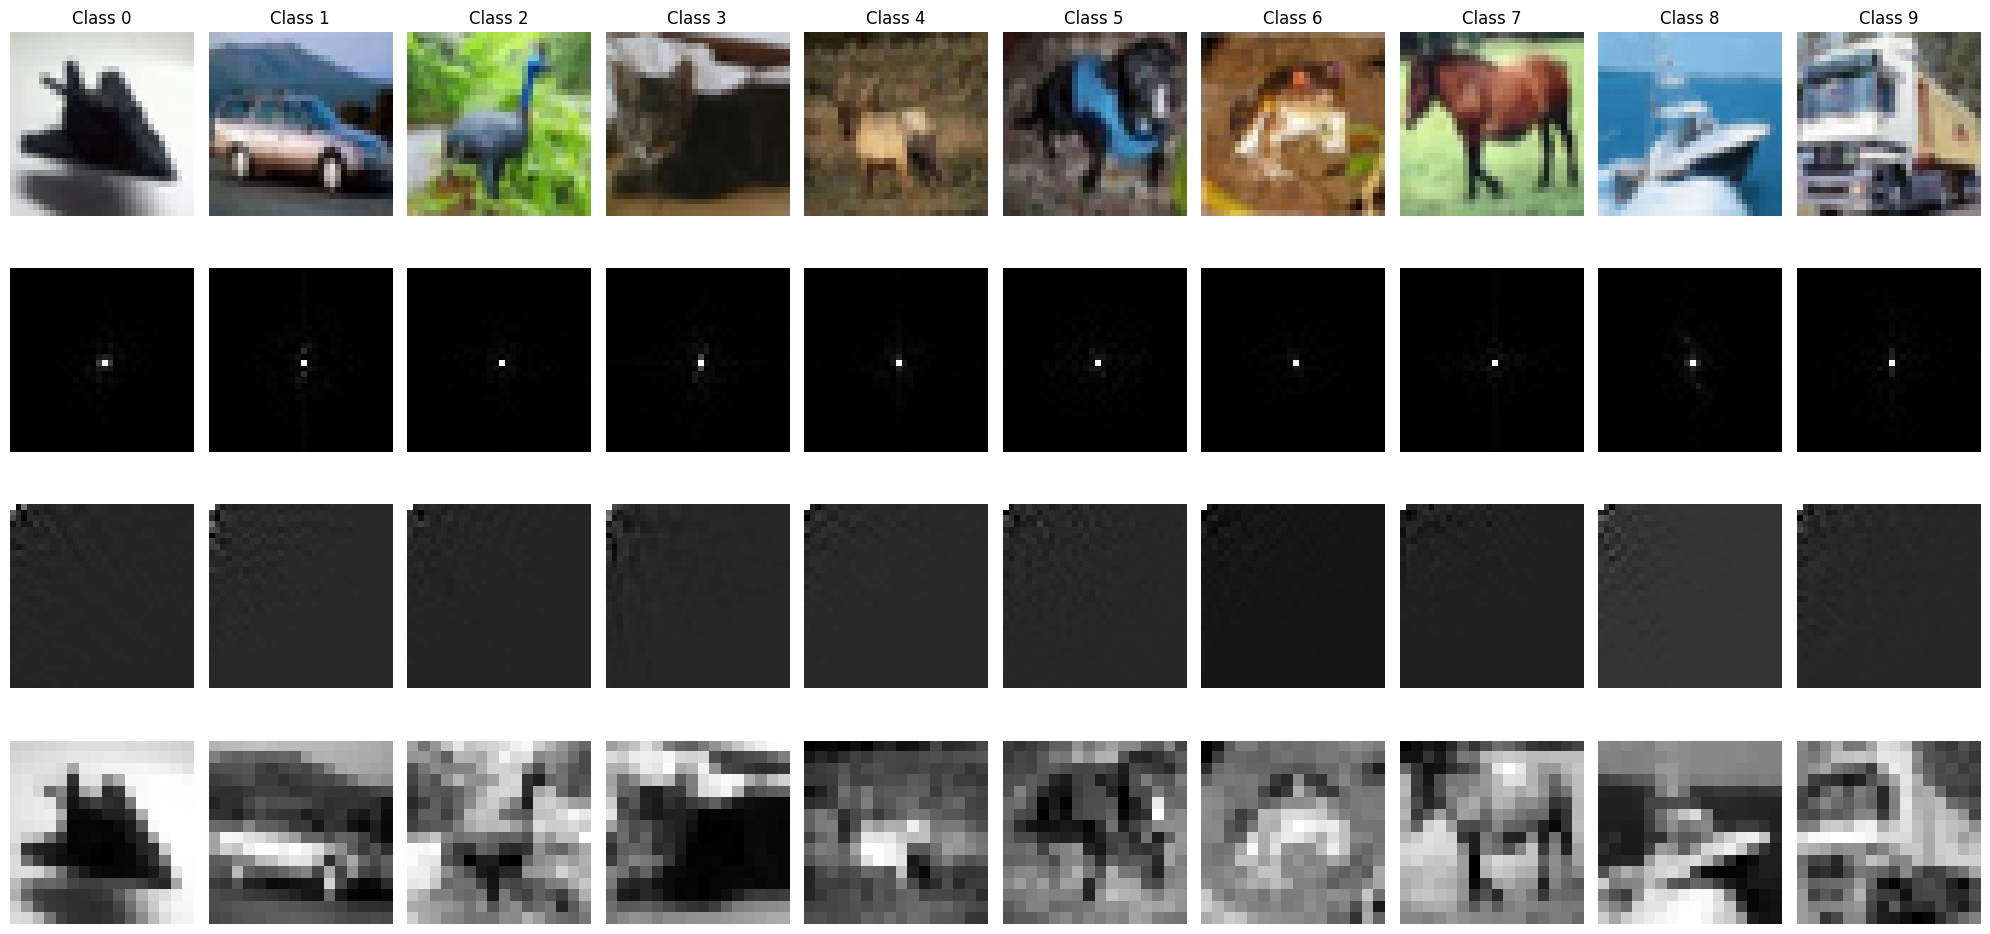

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift, dctn
import pywt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load and normalize CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Function to get a sample from each class (adapted for one-hot encoded labels)
def get_class_samples(data, labels, num_classes=10):
    class_samples = []
    labels = np.argmax(labels, axis=1)  # Convert one-hot labels to integer labels
    for i in range(num_classes):
        idx = np.where(labels == i)[0]  # Get all indices for each class
        if len(idx) > 0:
            class_samples.append(data[idx[0]])  # Take the first sample for each class
        else:
            print(f"Warning: No samples found for class {i}")
    return np.array(class_samples)

# FFT transformation (6 channels: real and imaginary parts)
def fft_transform(data):
    fft_data = np.fft.fft2(data, axes=(1, 2))  # Apply FFT to the spatial dimensions
    fft_data_shifted = np.fft.fftshift(fft_data, axes=(1, 2))  # Shift zero frequency to center
    real_part = np.real(fft_data_shifted)
    imag_part = np.imag(fft_data_shifted)
    # Concatenate real and imaginary parts along the last axis to create separate channels
    return np.concatenate([real_part, imag_part], axis=-1)

# DCT transformation
def dct_transform(data):
    dct_data = dctn(data, type=2, norm='ortho', axes=(1, 2))
    return dct_data

# Wavelet transformation (Haar wavelet)
def wavelet_transform(data, wavelet='haar'):
    transformed = []
    for img in data:
        channels = []
        for c in range(3):  # Apply wavelet transform to each channel
            coeffs = pywt.dwt2(img[:, :, c], wavelet)
            cA, (cH, cV, cD) = coeffs
            channels.append(np.stack((cA, cH, cV), axis=-1))  # Stack the components
        transformed.append(np.concatenate(channels, axis=-1))  # Concatenate along the channel axis
    return np.array(transformed)

# Get sample images for each class
class_samples = get_class_samples(x_train, y_train, num_classes)

# Create representations
class_samples_fft = fft_transform(class_samples)
class_samples_dct = dct_transform(class_samples)
class_samples_wavelet = wavelet_transform(class_samples)

# Plotting the representations
fig, axes = plt.subplots(4, num_classes, figsize=(20, 10))
transform_names = ['Spatial', 'FFT', 'DCT', 'Wavelet']

# Plot the original spatial images
for i in range(num_classes):
    axes[0, i].imshow(class_samples[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Class {i}')

# Plot FFT representations (real part for visualization)
for i in range(num_classes):
    fft_real = np.abs(class_samples_fft[i, :, :, 0])  # Real part
    axes[1, i].imshow(fft_real, cmap='gray')
    axes[1, i].axis('off')

# Plot DCT representations
for i in range(num_classes):
    axes[2, i].imshow(class_samples_dct[i, :, :, 0], cmap='gray')  # First channel as example
    axes[2, i].axis('off')

# Plot Wavelet representations (approximation coefficient)
for i in range(num_classes):
    axes[3, i].imshow(class_samples_wavelet[i, :, :, 0], cmap='gray')  # Approximation coefficients
    axes[3, i].axis('off')

# Set row labels
for ax, row in zip(axes[:, 0], transform_names):
    ax.set_ylabel(row, rotation=0, size='large')

plt.tight_layout()
plt.show()


Insight: Preprocessing data in different representations helps understand how different domains (spatial, frequency, etc.) influence learning.

Step 2: Build and Train Models on Each Representation

Research Question: How do models trained on different representations perform in terms of accuracy and generalization?

Training on Spatial data...
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.3330 - loss: 2.0724 - val_accuracy: 0.5613 - val_loss: 1.2105 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5748 - loss: 1.2000 - val_accuracy: 0.6719 - val_loss: 0.9152 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6676 - loss: 0.9623 - val_accuracy: 0.6309 - val_loss: 2.5495 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6996 - loss: 0.8547 - val_accuracy: 0.7190 - val_loss: 0.7963 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7327 - loss: 0.7659 - val_accuracy: 0.7542 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7600 - loss: 0.6976 - val_accuracy: 0.7431 - val_loss: 0.7599 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step

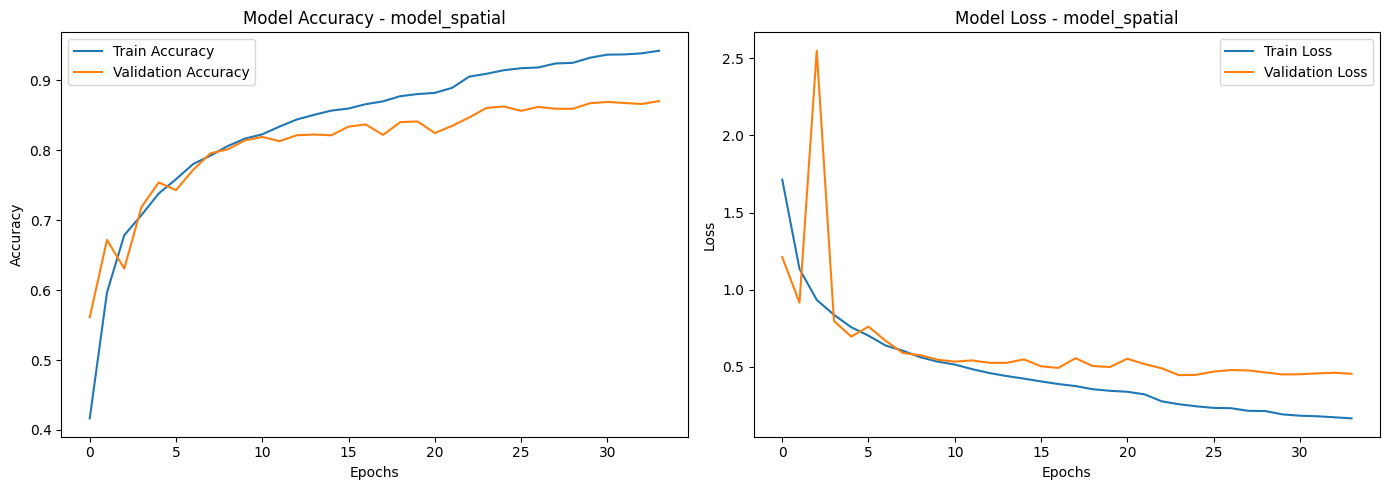


Training on FFT data...
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.2460 - loss: 2.3314 - val_accuracy: 0.4714 - val_loss: 1.4594 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4638 - loss: 1.4798 - val_accuracy: 0.5304 - val_loss: 1.2708 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5425 - loss: 1.2827 - val_accuracy: 0.5908 - val_loss: 1.1624 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5818 - loss: 1.1859 - val_accuracy: 0.6110 - val_loss: 1.0934 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6088 - loss: 1.1149 - val_accuracy: 0.6423 - val_loss: 1.0069 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6265 - loss: 1.0686 - val_accuracy: 0.6654 - val_loss: 0.9435 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step 

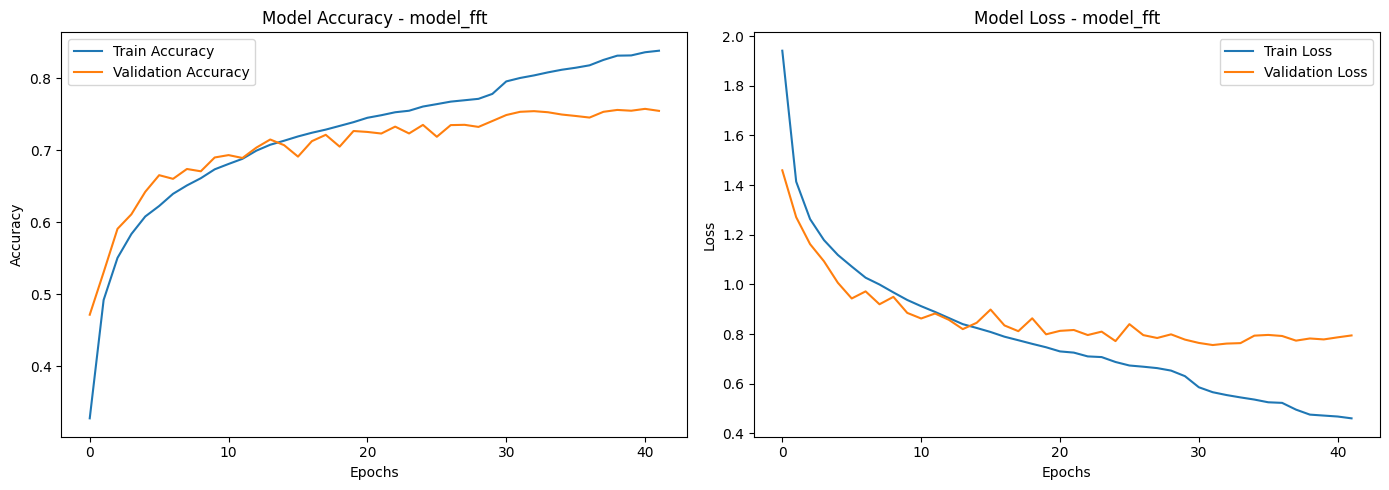


Training on DCT data...
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.2868 - loss: 2.2352 - val_accuracy: 0.5228 - val_loss: 1.3291 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5234 - loss: 1.3437 - val_accuracy: 0.5576 - val_loss: 1.2365 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5747 - loss: 1.2020 - val_accuracy: 0.5898 - val_loss: 1.1757 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6056 - loss: 1.1152 - val_accuracy: 0.5891 - val_loss: 1.2030 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6270 - loss: 1.0624 - val_accuracy: 0.6259 - val_loss: 1.0761 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6430 - loss: 1.0177 - val_accuracy: 0.6489 - val_loss: 0.9902 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/st

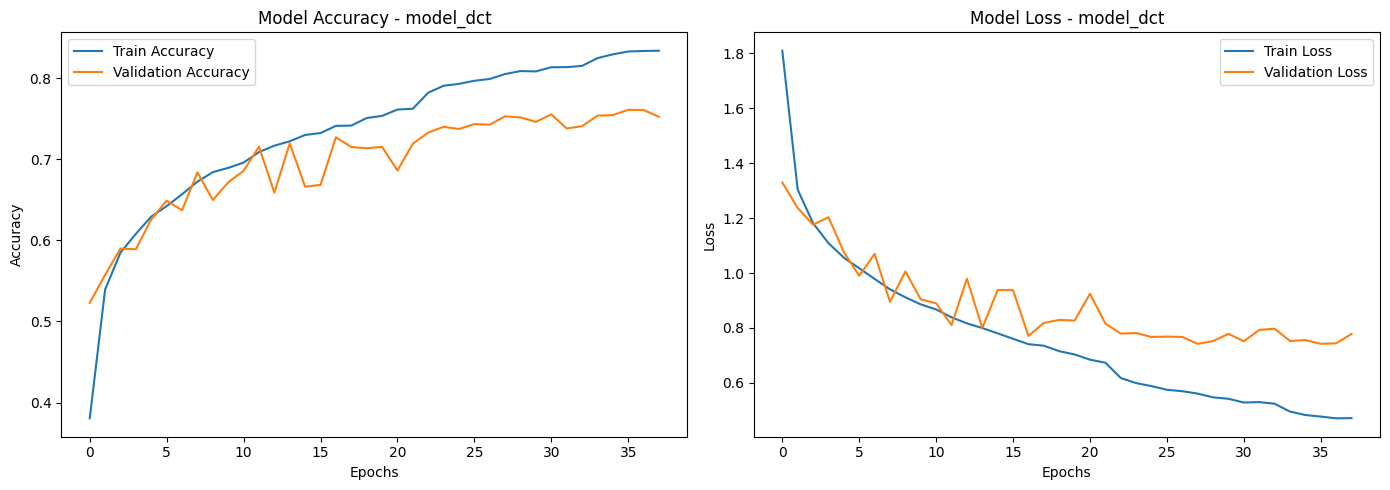


Training on Wavelet data...
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2773 - loss: 2.3401 - val_accuracy: 0.4822 - val_loss: 1.4155 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4826 - loss: 1.4408 - val_accuracy: 0.5345 - val_loss: 1.3044 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5659 - loss: 1.2156 - val_accuracy: 0.5987 - val_loss: 1.1081 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6141 - loss: 1.0922 - val_accuracy: 0.6486 - val_loss: 1.0095 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6486 - loss: 0.9992 - val_accuracy: 0.6744 - val_loss: 0.9255 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6796 - loss: 0.9149 - val_accuracy: 0.6361 - val_loss: 1.0602 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

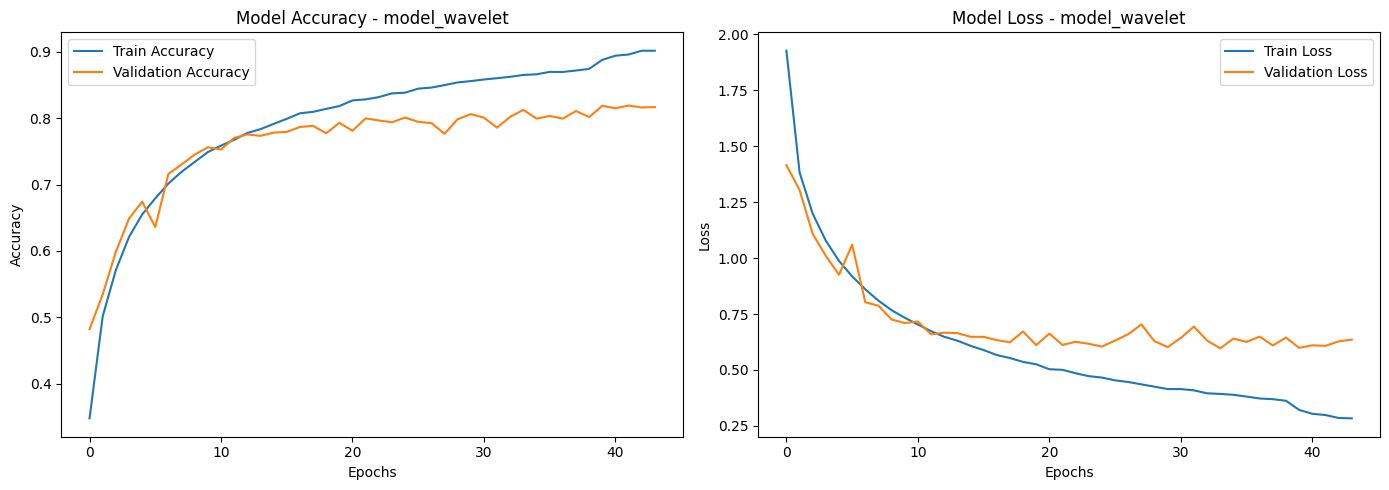

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

# Function to build a CNN model
def build_model(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='Vis_cnn_layer'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_callbacks(model_name):
    """
    Returns a list of callbacks for training.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_saver = ModelCheckpoint(f'{model_name}.keras', monitor='val_accuracy', mode='max', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    return [early_stopping, model_saver, reduce_lr]

def plot_learning_curve(history, model_name):
    """
    Plots the learning curves for training and validation accuracy and loss.
    """
    plt.figure(figsize=(14, 5))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(f'{model_name}_learning_curve.png')
    plt.show()

# Number of classes in CIFAR-10
num_classes = 10

# Train models on different representations
print("Training on Spatial data...")
model_spatial = build_model((32, 32, 3), num_classes)
callbacks_spatial = get_callbacks('model_spatial')
history_spatial = model_spatial.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks_spatial, verbose=1)
plot_learning_curve(history_spatial, 'model_spatial')

print("\nTraining on FFT data...")
model_fft = build_model((32, 32, 6), num_classes)
callbacks_fft = get_callbacks('model_fft')
history_fft = model_fft.fit(x_train_fft, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks_fft, verbose=1)
plot_learning_curve(history_fft, 'model_fft')

print("\nTraining on DCT data...")
model_dct = build_model((32, 32, 3), num_classes)
callbacks_dct = get_callbacks('model_dct')
history_dct = model_dct.fit(x_train_dct, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks_dct, verbose=1)
plot_learning_curve(history_dct, 'model_dct')

print("\nTraining on Wavelet data...")
model_wavelet = build_model((16, 16, 9), num_classes)  # Adjusted for wavelet output shape
callbacks_wavelet = get_callbacks('model_wavelet')
history_wavelet = model_wavelet.fit(x_train_wavelet, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks_wavelet, verbose=1)
plot_learning_curve(history_wavelet, 'model_wavelet')


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Function to build a CNN model
def build_model(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='Vis_cnn_layer'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Function to get callbacks with model-specific file paths
def get_callbacks(model_name, fold):
    os.makedirs('models', exist_ok=True)  # Directory for saved models
    os.makedirs('learning_curves', exist_ok=True)  # Directory for learning curves
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_saver = ModelCheckpoint(f'models/{model_name}_fold{fold}.keras', monitor='val_accuracy', mode='max', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    
    return [early_stopping, model_saver, reduce_lr]

# Function to plot and save learning curve
def plot_learning_curve(history, model_name, fold):
    plt.figure(figsize=(14, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy - {model_name} Fold {fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss - {model_name} Fold {fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(f'learning_curves/{model_name}_fold{fold}_learning_curve.png')
    plt.show()

# Dictionary to hold each model representation
models = {
    'model_spatial': lambda: build_model((32, 32, 3), 10),
    'model_fft': lambda: build_model((32, 32, 6), 10),
    'model_dct': lambda: build_model((32, 32, 3), 10),
    'model_wavelet': lambda: build_model((16, 16, 9), 10),
}

# Load and preprocess data for each representation (from PDF code)
x_datasets = {
    'model_spatial': x_train,
    'model_fft': x_train_fft,
    'model_dct': x_train_dct,
    'model_wavelet': x_train_wavelet,
}

# Convert labels to categorical
y_train_categorical = tf.keras.utils.to_categorical(y_train, 10)

# Data structure to store results for each model and fold
results = []

# K-fold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
for model_name, model_fn in models.items():
    print(f"\nEvaluating {model_name} with cross-validation...")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(y_train_categorical)):
        print(f"Fold {fold + 1}")
        
        # Split data for current fold
        x_train_fold, x_val_fold = x_datasets[model_name][train_idx], x_datasets[model_name][val_idx]
        y_train_fold, y_val_fold = y_train_categorical[train_idx], y_train_categorical[val_idx]
        
        # Initialize a new model instance
        model = model_fn()
        callbacks = get_callbacks(model_name, fold + 1)

        # Train the model on this fold
        history = model.fit(
            x_train_fold, y_train_fold, 
            epochs=50, batch_size=64, 
            validation_data=(x_val_fold, y_val_fold), 
            callbacks=callbacks, verbose=0
        )

        # Plot and save the learning curve for the current fold
        plot_learning_curve(history, model_name, fold + 1)

        # Evaluate the model and collect metrics
        accuracy, precision, recall, f1 = evaluate_model(model, x_val_fold, y_val_fold)
        results.append({
            'model': model_name,
            'fold': fold + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Calculate mean and standard deviation for each metric
metrics_summary = results_df.groupby('model').agg({
    'accuracy': ['mean', 'std'],
    'precision': ['mean', 'std'],
    'recall': ['mean', 'std'],
    'f1_score': ['mean', 'std']
}).reset_index()

# Display the cross-validation metrics for statistical analysis
import ace_tools as tools; tools.display_dataframe_to_user(name="Cross-Validation Metrics Summary", dataframe=metrics_summary)

# Determine the best model for each representation based on the highest mean accuracy
best_models = metrics_summary.loc[metrics_summary.groupby('model')['accuracy']['mean'].idxmax()]
print("\nBest Models per Representation:")
print(best_models)


NameError: name 'x_train_fft' is not defined

Insight: Training models on different data representations helps identify which representation leads to better performance and generalization.

Step 3: Extract and Visualize Activation Maps

Research Question: What features are highlighted by models trained on different data representations?


Visualizing activation maps for models...


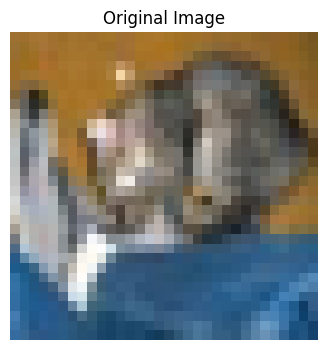

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


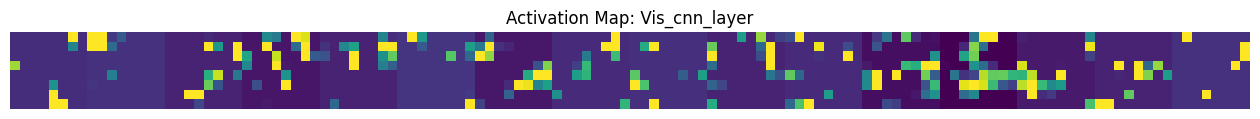

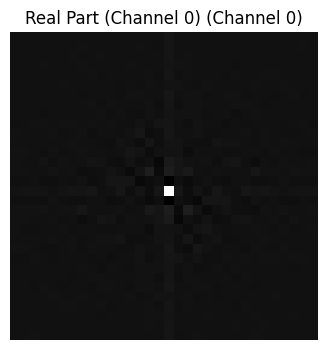

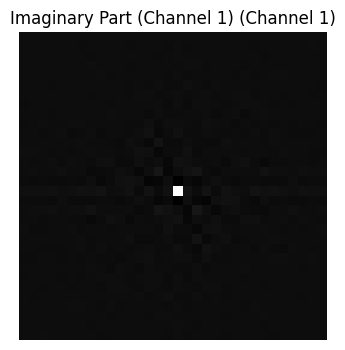

/home/cs/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1662']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


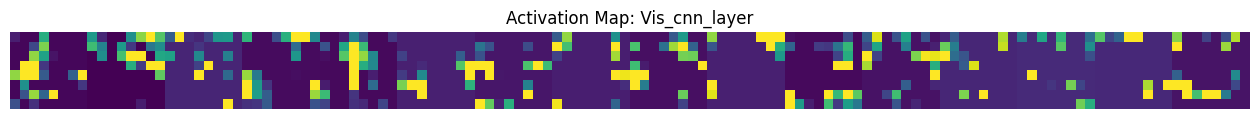

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.923506..13.900247].


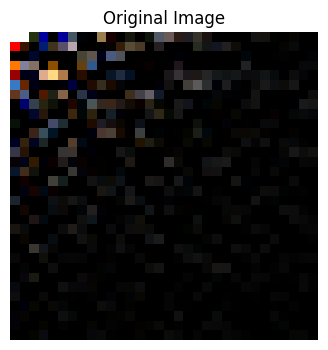

/home/cs/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1939']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


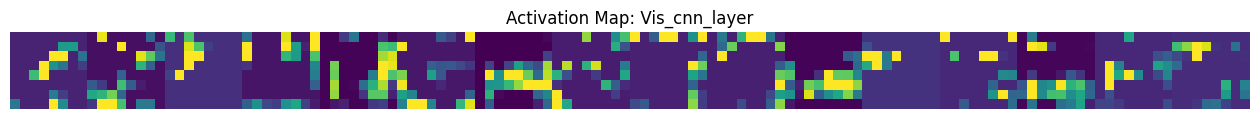

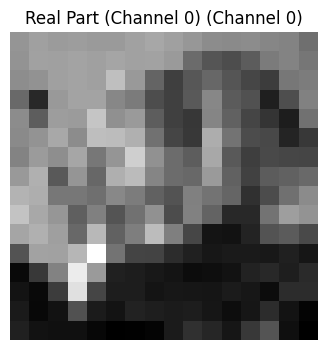

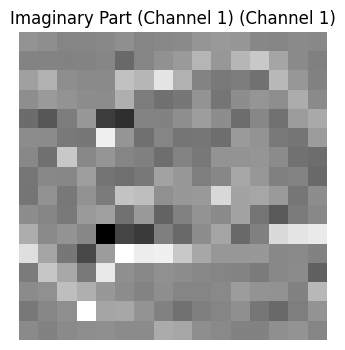

/home/cs/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_2216']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


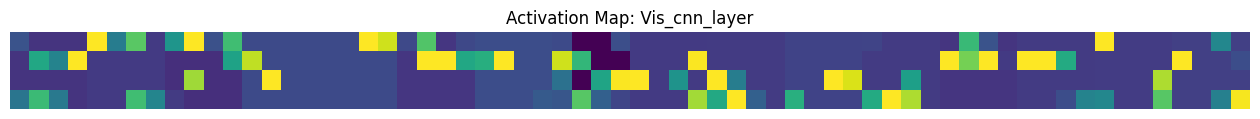

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


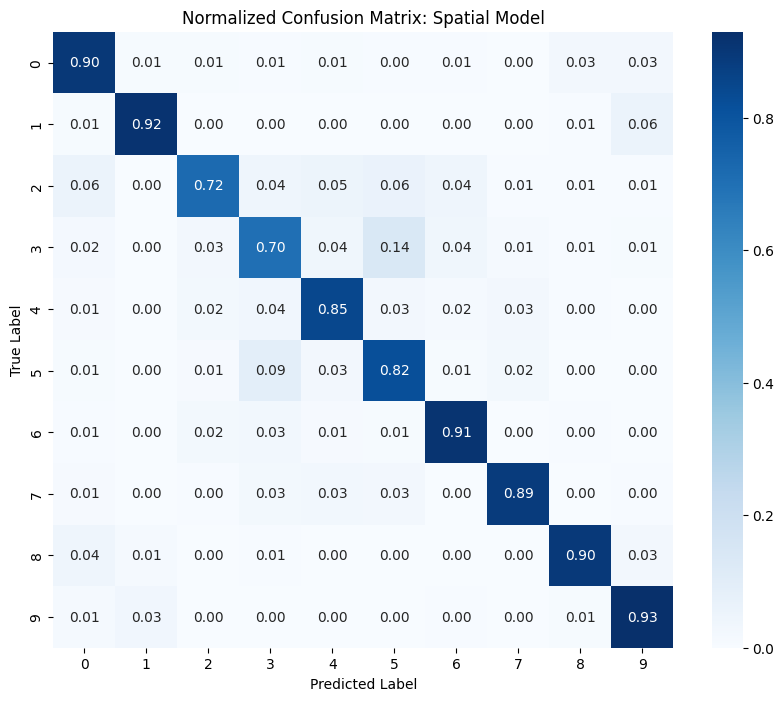


Classification Report for Spatial Model:

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1000
           1       0.93      0.92      0.92      1000
           2       0.87      0.72      0.79      1000
           3       0.74      0.70      0.72      1000
           4       0.83      0.85      0.84      1000
           5       0.75      0.82      0.78      1000
           6       0.88      0.91      0.89      1000
           7       0.92      0.89      0.90      1000
           8       0.93      0.90      0.91      1000
           9       0.87      0.93      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


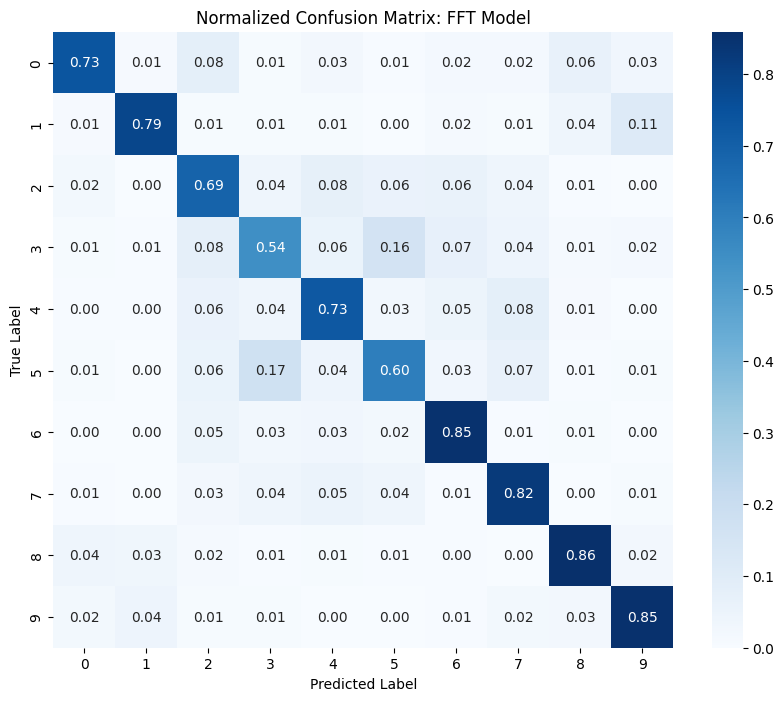


Classification Report for FFT Model:

              precision    recall  f1-score   support

           0       0.85      0.73      0.79      1000
           1       0.88      0.79      0.83      1000
           2       0.64      0.69      0.67      1000
           3       0.61      0.54      0.57      1000
           4       0.70      0.73      0.72      1000
           5       0.65      0.60      0.63      1000
           6       0.76      0.85      0.80      1000
           7       0.74      0.82      0.78      1000
           8       0.83      0.86      0.85      1000
           9       0.80      0.85      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


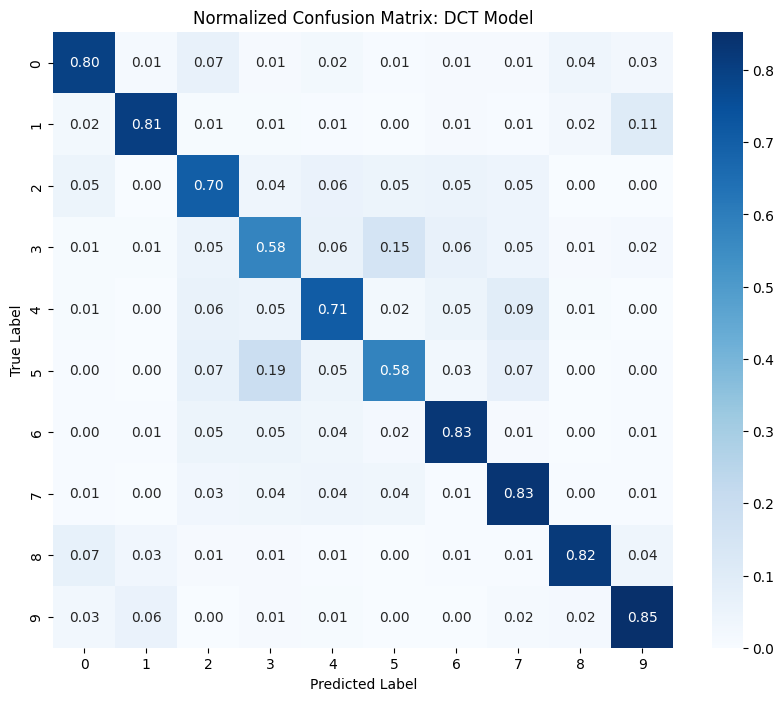


Classification Report for DCT Model:

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1000
           1       0.87      0.81      0.84      1000
           2       0.67      0.70      0.68      1000
           3       0.59      0.58      0.58      1000
           4       0.71      0.71      0.71      1000
           5       0.67      0.58      0.62      1000
           6       0.78      0.83      0.80      1000
           7       0.73      0.83      0.78      1000
           8       0.88      0.82      0.85      1000
           9       0.81      0.85      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


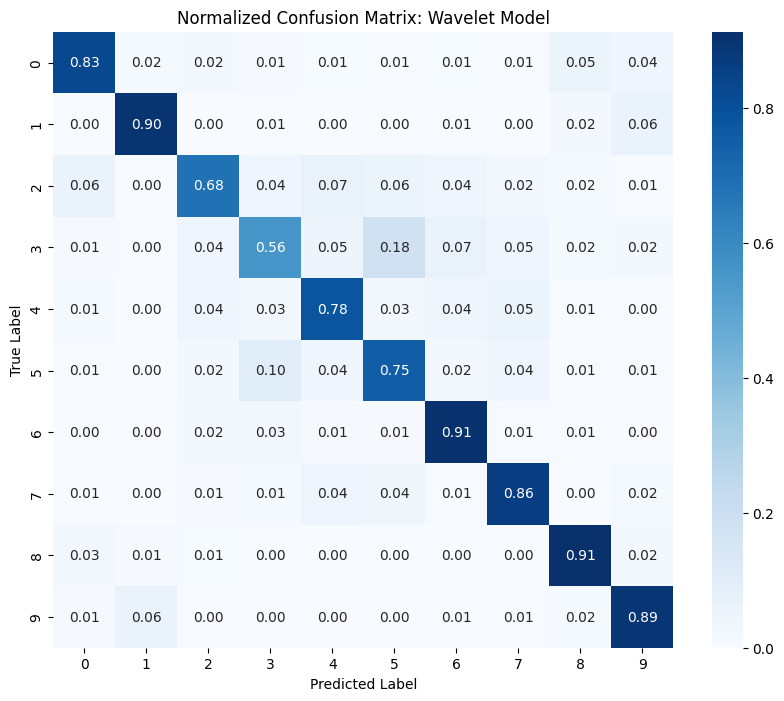


Classification Report for Wavelet Model:

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1000
           1       0.90      0.90      0.90      1000
           2       0.80      0.68      0.74      1000
           3       0.70      0.56      0.62      1000
           4       0.78      0.78      0.78      1000
           5       0.69      0.75      0.72      1000
           6       0.81      0.91      0.86      1000
           7       0.83      0.86      0.84      1000
           8       0.87      0.91      0.89      1000
           9       0.84      0.89      0.86      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model

# Function to display a specific channel from an image with multiple channels
def display_single_channel(image, channel_index=0, title="Image Channel"):
    """
    Display a specific channel from an image with multiple channels.
    """
    if channel_index >= image.shape[-1]:
        print(f"Invalid channel index: {channel_index}. The image has {image.shape[-1]} channels.")
        return
    
    channel_image = image[:, :, channel_index]
    plt.figure(figsize=(4, 4))
    plt.imshow(channel_image, cmap='gray')
    plt.title(f'{title} (Channel {channel_index})')
    plt.axis('off')
    plt.show()

# Function to extract and visualize activation maps with the original input image
def visualize_activation_maps_with_input(model, data, layer_name, sample_index=0):
    original_image = data[sample_index]
    
    # Display the original image or channels of the original image
    if original_image.shape[-1] > 3:  # Assuming more than 3 channels means complex data (e.g., FFT)
        display_single_channel(original_image, 0, "Real Part (Channel 0)")
        display_single_channel(original_image, 1, "Imaginary Part (Channel 1)")
    else:
        plt.figure(figsize=(4, 4))
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')
        plt.show()

    # Extract and visualize activation maps
    try:
        layer_output = model.get_layer(layer_name).output
    except ValueError as e:
        print(f"Error: {e}")
        return

    activation_model = Model(inputs=model.inputs, outputs=layer_output)
    activations = activation_model.predict(data[sample_index:sample_index + 1])

    num_features = activations.shape[-1]
    size = activations.shape[1]
    n_cols = num_features // 8 if num_features >= 8 else num_features

    display_grid = np.zeros((size, n_cols * size))

    for col in range(n_cols):
        channel_image = activations[0, :, :, col]
        channel_image -= channel_image.mean()
        channel_image /= (channel_image.std() + 1e-5)
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[:, col * size: (col + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(f'Activation Map: {layer_name}')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.axis('off')
    plt.show()

# Function to plot a normalized confusion matrix
def plot_normalized_confusion_matrix(model, x_data, y_true, model_name):
    y_pred = np.argmax(model.predict(x_data), axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    conf_matrix = confusion_matrix(y_true_labels, y_pred, normalize='true')  # Normalize by row

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title(f'Normalized Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true_labels, y_pred))

# Ensure models are called at least once
_ = model_spatial(x_test[:1])
_ = model_fft(x_test_fft[:1])
_ = model_dct(x_test_dct[:1])
_ = model_wavelet(x_test_wavelet[:1])

# Visualize activation maps with corresponding input image
print("\nVisualizing activation maps for models...")
visualize_activation_maps_with_input(model_spatial, x_test, 'Vis_cnn_layer')
visualize_activation_maps_with_input(model_fft, x_test_fft, 'Vis_cnn_layer')
visualize_activation_maps_with_input(model_dct, x_test_dct, 'Vis_cnn_layer')
visualize_activation_maps_with_input(model_wavelet, x_test_wavelet, 'Vis_cnn_layer')

# Plot and compare normalized confusion matrices
plot_normalized_confusion_matrix(model_spatial, x_test, y_test, 'Spatial Model')
plot_normalized_confusion_matrix(model_fft, x_test_fft, y_test, 'FFT Model')
plot_normalized_confusion_matrix(model_dct, x_test_dct, y_test, 'DCT Model')
plot_normalized_confusion_matrix(model_wavelet, x_test_wavelet, y_test, 'Wavelet Model')


Insight: Analyzing activation maps provides a qualitative understanding of how different data representations impact feature extraction in the models.

Step 4: Correlate Activation Maps Across Representations

Research Question: How similar are the learned features across different data representations?

In [13]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

# Function to extract feature maps from a specified layer
def extract_feature_maps(model, data, layer_name, sample_size=100):
    # Ensure the layer exists
    try:
        layer_output = model.get_layer(layer_name).output
    except ValueError as e:
        print(f"Error: {e}")
        return None

    # Create model to extract features from the specific layer
    activation_model = Model(inputs=model.inputs, outputs=layer_output)
    activations = activation_model.predict(data[:sample_size])
    # Flatten the feature maps
    feature_maps = activations.reshape(sample_size, -1)
    return feature_maps

# Function to compute correlation between two sets of features
def compute_correlation(features1, features2):
    correlations = []
    for i in range(features1.shape[1]):
        corr, _ = pearsonr(features1[:, i], features2[:, i])
        if np.isnan(corr):  # Handle NaNs
            corr = 0
        correlations.append(corr)
    return np.mean(correlations)

# Function to extract and reduce features using PCA
def extract_and_reduce_features(model, data, layer_name, sample_size=100, n_components=50):
    feature_maps = extract_feature_maps(model, data, layer_name, sample_size)
    if feature_maps is None:
        return None
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(feature_maps)
    return reduced_features

# Extract features for correlation analysis
print("\nExtracting features and reducing dimensionality...")
features_spatial_pca = extract_and_reduce_features(model_spatial, x_test, 'Vis_cnn_layer')
features_fft_pca = extract_and_reduce_features(model_fft, x_test_fft, 'Vis_cnn_layer')
features_dct_pca = extract_and_reduce_features(model_dct, x_test_dct, 'Vis_cnn_layer')
features_wavelet_pca = extract_and_reduce_features(model_wavelet, x_test_wavelet, 'Vis_cnn_layer')

# Compute correlations between the feature representations
print("\nComputing correlation between different representations...")
if features_spatial_pca is not None and features_fft_pca is not None:
    corr_spatial_fft = compute_correlation(features_spatial_pca, features_fft_pca)
if features_spatial_pca is not None and features_dct_pca is not None:
    corr_spatial_dct = compute_correlation(features_spatial_pca, features_dct_pca)
if features_spatial_pca is not None and features_wavelet_pca is not None:
    corr_spatial_wavelet = compute_correlation(features_spatial_pca, features_wavelet_pca)
if features_fft_pca is not None and features_dct_pca is not None:
    corr_fft_dct = compute_correlation(features_fft_pca, features_dct_pca)
if features_fft_pca is not None and features_wavelet_pca is not None:
    corr_fft_wavelet = compute_correlation(features_fft_pca, features_wavelet_pca)
if features_dct_pca is not None and features_wavelet_pca is not None:
    corr_dct_wavelet = compute_correlation(features_dct_pca, features_wavelet_pca)

# Print correlation results
print("\nCorrelation Analysis:")
print(f"Correlation between Spatial and FFT: {corr_spatial_fft:.4f}")
print(f"Correlation between Spatial and DCT: {corr_spatial_dct:.4f}")
print(f"Correlation between Spatial and Wavelet: {corr_spatial_wavelet:.4f}")
print(f"Correlation between FFT and DCT: {corr_fft_dct:.4f}")
print(f"Correlation between FFT and Wavelet: {corr_fft_wavelet:.4f}")
print(f"Correlation between DCT and Wavelet: {corr_dct_wavelet:.4f}")



Extracting features and reducing dimensionality...


/home/cs/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1385']. Received: the structure of inputs=*
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


/home/cs/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1662']. Received: the structure of inputs=*
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


/home/cs/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1939']. Received: the structure of inputs=*
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


/home/cs/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_2216']. Received: the structure of inputs=*
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step

Computing correlation between different representations...

Correlation Analysis:
Correlation between Spatial and FFT: -0.0110
Correlation between Spatial and DCT: -0.0810
Correlation between Spatial and Wavelet: 0.0857
Correlation between FFT and DCT: -0.0174
Correlation between FFT and Wavelet: 0.0140
Correlation between DCT and Wavelet: -0.0280


Insight: Correlation analysis provides quantitative insights into how similar or unique the learned features are across different data representations. High correlation implies shared features, while low correlation indicates unique feature representations.